In [1]:
#importing part

import numpy as np
import tt
from tt.eigb import *

from scipy import optimize as opt
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [2]:
def J_gen(L,j1,j2):
    J = np.zeros((L*L, L*L))
    for i in range(L):
        for j in range(L):
            J[i * L + j, i * L + ((j + 1) % L)] = j1
            J[i * L + j, ((i + 1) % L) * L + j] = j1
            J[i * L + j, ((i + 1) % L) * L + ((j + 1) % L)] = j2
            J[i * L + j, ((i + 1) % L) * L + ((j - 1) % L)] = j2
    J = 0.5 * (J + J.T)
    return J

def H_gen(J):
    def H_f(n):
        a = []
        for m in n:
            m = int(m)
            s = np.array([(m // 2**i) % 2 for i in range(N)]) - 0.5 * np.ones(N)
            a.append(-1 * (s.T @ J @ s))
        return a

    N = J.shape[0]
    x = tt.xfun(n = 2, d = N)
    H = tt.multifuncrs([x], H_f, 1e-8, y0 = tt.rand(n = 2, d = N), verb = 0, rmax = 15)
    H = tt.diag(H)
    return(H)

def X_gen(n):
    head = np.zeros((1,2,2,2))
    head[0,0,0,0] = 1
    head[0,1,1,0] = 1
    head[0,1,0,1] = 1
    head[0,0,1,1] = 1

    body = np.zeros((2,2,2,2))
    body[0,0,0,0] = 1
    body[0,1,1,0] = 1
    body[0,0,1,1] = 1
    body[0,1,0,1] = 1
    body[1,0,0,1] = 1
    body[1,1,1,1] = 1

    tail = np.zeros((2,2,2,1))
    tail[0,1,0,0] = 1
    tail[0,0,1,0] = 1
    tail[1,0,0,0] = 1
    tail[1,1,1,0] = 1

    a = [head]
    for i in range(n-2):
        a.append(body)
    a.append(tail)
    result = tt.matrix.from_list(a)
    return result

def project_gen(state):
    a = tt.vector.to_list(state)
    b = []
    c = []
    for x in a:
        shape = x.shape
        b.append(x.reshape(shape[0],shape[1],-1,shape[2]))
        c.append((x[:,::-1,:]).reshape(shape[0],shape[1],-1,shape[2]))
    M1 = tt.matrix.from_list(b)
    M2 = tt.matrix.from_list(c)
    return M1 @ M1.T
    #return M1 @ M1.T + M2 @ M2.T

def get_data_ALS(L, Kappa, Field, N, M):
    j1 = 1 
    j2 = -1 * Kappa

    H_x = X_gen(L*L)
    J = J_gen(L, j1, j2)
    H = H_gen(J)
    
    a = []
    for i in range(N):
        Field = 1 * (1 - (i + 1) / N)
        b = []
        H_proj = 0 * project_gen(tt.rand(n = 2, d = L * L, r = 2))

        for j in range(M):
            x = tt.rand(n = 2, d = L * L, r = 2)
            y, lam = eigb(H + Field * H_x + 100 * H_proj, x, 1e-14,verb = 0, nswp = 30)
            H_proj = H_proj + project_gen(y)
            b.append(float(lam))
        a.append(np.sort(b))
        if( (i+1) % (10) == 0): print((i+1), "/", N)
    a = (1/ L * L) * np.array(a).T
    return a

def clasterization(array, eps):
    N = array.shape[0]
    X = np.array([(1/N) * np.array(range(N)), array]).T
    clusteringX = DBSCAN(eps = eps, min_samples=2).fit(X)
    b = []
    for i in range(N):
        if(clusteringX.labels_[i] == 0):
            b.append(X[i])
    return ((np.array(b).T)[0], (np.array(b).T)[1])
    

In [21]:
a = get_data_ALS(L = 5, Kappa = 0.25, Field = 1, N = 100, M = 3)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


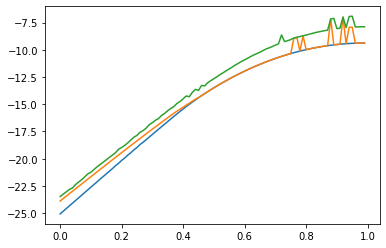

In [22]:
N = 100
K = 1
for x in a:
    plt.plot( (1 / (N - K + 1)) * np.array(range(N - K + 1)), np.convolve(x, np.ones(K)/K, mode='valid'))


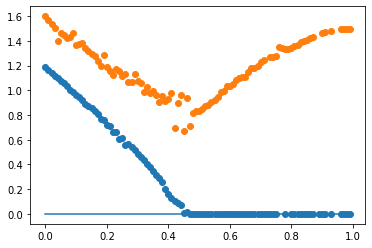

In [24]:
b = clasterization(array = a[1] - a[0], eps = 0.2)
c = clasterization(array = a[2] - a[0], eps = 0.2)

plt.scatter(b[0],b[1])
plt.scatter(c[0],c[1])
plt.plot((1/N) * np.array(range(N)), np.zeros(N))

In [6]:
print(get_data_ALS(L = 5, Kappa = 0.3, Field = 0, N = 1, M = 3))

[[-8.75]
 [-8.75]
 [-7.35]]
